In [28]:
import matplotlib.pyplot as plt
import numpy as np

def plot_policy(values, title):
    policy = np.zeros_like(values, dtype='<U2')
    n, m = values.shape
    for i in range(n):
        for j in range(m):
            best_action = None
            best_value = -np.inf
            directions = {'U': (-1, 0), 'D': (1, 0), 'L': (0, -1), 'R': (0, 1)}
            for d, (di, dj) in directions.items():
                ni, nj = i + di, j + dj
                if 0 <= ni < n and 0 <= nj < m:
                    if values[ni, nj] > best_value:
                        best_value = values[ni, nj]
                        best_action = d
            if best_action:
                policy[i, j] = best_action.replace('U', '↑').replace('D', '↓').replace('L', '←').replace('R', '→')

    plt.imshow(np.ones_like(values), cmap='gray', alpha=0.3)
    colors = np.ones((n, m, 3))  # Set default color to white
    colors[0, 1] = [0, 0, 1]  # Blue for 1st row, 2nd column
    colors[0, 4] = [0, 1, 0]  # Green for 1st row, 5th column
    colors[3, 2] = [1, 0, 0]  # Red for 4th row, 3rd column
    colors[4, 4] = [1, 1, 0]  # Yellow for 5th row, 5th column
    
    plt.imshow(colors, alpha=1)

    for i in range(n):
        for j in range(m):
            color = 'black'
            plt.text(j, i, policy[i, j], ha='center', va='center', color=color)
    
    plt.title(title)
    plt.xticks([])
    plt.yticks([])
    plt.show()

# Example usage with mock data
# values = np.random.rand(5, 5)  # Replace with actual values array
# plot_policy(values, "Policy Visualization")




# 2. Iterative Policy Evaluation

In [38]:
# import numpy as np

# def initialize_grid():
#     grid = np.zeros((5, 5))
#     rewards = {(0, 1): 5, (0, 3): 2.5, (1, 1): 0.5, (1, 3): -1}
#     return grid, rewards

# def is_terminal_state(x, y):
#     if (x, y) in [(0, 1), (0, 3), (1, 1), (1, 3)]:  # terminal states with unique rewards and transitions
#         return True
#     return False

# def get_next_state_reward(x, y):
#     if (x, y) == (0, 1):
#         return (1, 1), 5  # Teleports to the red square
#     elif (x, y) == (0, 3):
#         if np.random.rand() < 0.5:
#             return (1, 1), 2.5  # 50% chance to teleport to red
#         else:
#             return (1, 3), 2.5  # 50% chance to teleport to yellow
#     elif (x, y) == (1, 1):
#         return (1, 1), 0.5  # Stays in place
#     elif (x, y) == (1, 3):
#         return (1, 3), -1  # Stays in place
#     return (x, y), 0  # Default reward for non-special states

# def iterate_value(grid):
#     gamma = 0.95
#     new_grid = np.copy(grid)
#     for x in range(5):
#         for y in range(5):
#             if not is_terminal_state(x, y):
#                 values = []
#                 for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:  # possible moves
#                     nx, ny = x + dx, y + dy
#                     if 0 <= nx < 5 and 0 <= ny < 5:
#                         next_state, reward = get_next_state_reward(nx, ny)
#                         values.append(reward + gamma * grid[next_state])
#                     else:
#                         values.append(-0.5 + gamma * grid[x, y])  # penalty for off-grid move
#                 new_grid[x, y] = np.mean(values)
#     return new_grid

# def main():
#     grid, rewards = initialize_grid()
#     for _ in range(10000):  # Arbitrary number of iterations for convergence
#         grid = iterate_value(grid)
#     print()
#     print(grid)
#     plot_policy(grid,"2. Iterative Policy")

# if __name__ == "__main__":
#     main()


Value Function Grid:
          0         1         2         3         4
0  2.376320  5.000000  2.337893  1.606109  2.288008
1  1.305552  1.998917  1.426075  1.056872  0.956763
2  0.342589  0.684867  0.610845  0.461039  0.253148
3 -0.364209 -0.068702  0.000000  0.020350 -0.078746
4 -0.916873 -0.609928 -0.446298 -0.296607  0.000000


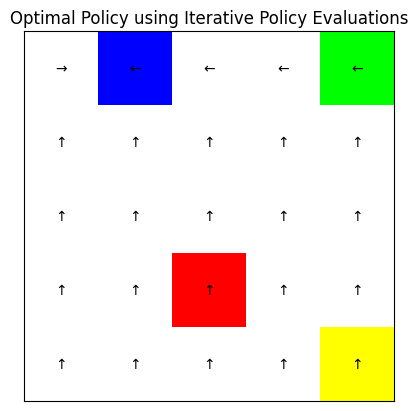

In [48]:
import numpy as np
import pandas as pd

# Parameters
gamma = 0.95  # discount factor
theta = 1e-6  # small threshold for convergence
actions = ['up', 'down', 'left', 'right']
action_prob = 0.25  # probability for each action

# Grid dimensions
nrows, ncols = 5, 5

# Rewards and transitions
rewards = np.zeros((nrows, ncols))
transitions = {}

# Special states
special_states = {
    (0, 1): {'reward': 5, 'transitions': [(3, 2)]},  # Blue square
    (0, 4): {'reward': 2.5, 'transitions': [(4, 4), (4, 2)]},  # Green square
    (3, 2): {'reward': 0},  # Red square
    (4, 4): {'reward': 0},  # Yellow square
}

# Initialize the value function
V = np.zeros((nrows, ncols))

# Define the possible movements
movements = {
    'up': (-1, 0),
    'down': (1, 0),
    'left': (0, -1),
    'right': (0, 1),
}

def get_next_state(row, col, action):
    move = movements[action]
    next_row = row + move[0]
    next_col = col + move[1]

    # If the agent moves off the grid, it stays in the same state
    if next_row < 0 or next_row >= nrows or next_col < 0 or next_col >= ncols:
        return row, col, -0.5  # off-grid penalty
    return next_row, next_col, 0

def evaluate_policy():
    while True:
        delta = 0
        for row in range(nrows):
            for col in range(ncols):
                if (row, col) in special_states:
                    special = special_states[(row, col)]
                    v = special['reward']
                    if 'transitions' in special:
                        v += gamma * sum(
                            [V[next_row, next_col] for next_row, next_col in special['transitions']]
                        ) / len(special['transitions'])
                else:
                    v = 0
                    for action in actions:
                        next_row, next_col, reward = get_next_state(row, col, action)
                        v += action_prob * (reward + gamma * V[next_row, next_col])
                delta = max(delta, np.abs(v - V[row, col]))
                V[row, col] = v
        if delta < theta:
            break

# Run policy evaluation
evaluate_policy()

df = pd.DataFrame(V)
print("Value Function Grid:")
print(df)
plot_policy(V,"Optimal Policy using Iterative Policy Evaluations")


# 1. Bellman Equations

In [39]:
# import numpy as np

# def setup_system():
#     # Define the dimensions of the grid
#     n = 5
#     V = np.zeros(n * n)  # Initialize the values of all states to zero
#     R = np.zeros(n * n)  # Reward for each state
#     P = np.zeros((n * n, n * n))  # Transition probabilities

#     # Setting up rewards and transition probabilities
#     # Map (x, y) to a linear index idx = x * n + y for easier matrix manipulation
#     def idx(x, y):
#         return x * n + y

#     # Define rewards and transitions
#     R[idx(0, 1)] = 5
#     R[idx(0, 3)] = 2.5
#     R[idx(1, 1)] = 0.5
#     R[idx(1, 3)] = -1

#     # Transitions
#     # Assuming each non-terminal action leads uniformly to its neighbors or itself if off-grid
#     for x in range(n):
#         for y in range(n):
#             current_idx = idx(x, y)
#             neighbors = []
#             if x > 0: neighbors.append(idx(x-1, y))
#             if x < n-1: neighbors.append(idx(x+1, y))
#             if y > 0: neighbors.append(idx(x, y-1))
#             if y < n-1: neighbors.append(idx(x, y+1))
            
#             if not neighbors:  # If no valid moves, return to itself (corner case for isolated states, not expected here)
#                 neighbors.append(current_idx)
            
#             for neighbor in neighbors:
#                 P[current_idx, neighbor] += 1.0 / len(neighbors)

#     # Adjust for special transitions
#     P[idx(0, 1), :] = 0
#     P[idx(0, 1), idx(1, 1)] = 1  # Blue to Red

#     P[idx(0, 3), :] = 0
#     P[idx(0, 3), idx(1, 1)] = 0.5  # Green to Red
#     P[idx(0, 3), idx(1, 3)] = 0.5  # Green to Yellow

#     # Red and Yellow are terminal in behavior but not absorbing states
#     P[idx(1, 1), :] = 0
#     P[idx(1, 1), idx(1, 1)] = 1  # Red stays

#     P[idx(1, 3), :] = 0
#     P[idx(1, 3), idx(1, 3)] = 1  # Yellow stays

#     return V, R, P

# def solve_bellman(V, R, P, gamma=0.95):
#     # The Bellman equation for v_pi is: v = R + gamma * P * v
#     # Rearrange to (I - gamma * P) * v = R
#     n = len(V)
#     A = np.eye(n) - gamma * P
#     b = R
#     V = np.linalg.solve(A, b)
#     return V.reshape((5, 5))

# def main():
#     V, R, P = setup_system()
#     solution = solve_bellman(V, R, P)
#     print("Solution to the system of Bellman equations:")
#     print(solution)
#     plot_policy(solution,"1. Optimal Policy for Bellman Equations")

# if __name__ == "__main__":
#     main()


[[ 3.20497185  5.          2.58699068  1.82323264  2.5       ]
 [ 2.08467462  2.29281086  1.48236902  0.7665457  -0.01490769]
 [ 1.19512002  1.08689682  0.59520652 -0.06313312 -1.20914409]
 [ 0.66539284  0.49327025  0.         -0.41843179 -1.69868494]
 [ 0.44787096  0.32463769  0.10111666  0.         -1.72083366]]


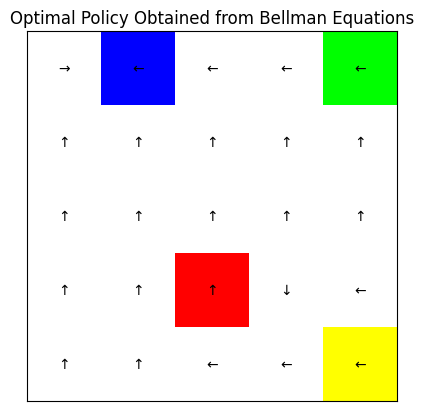

In [46]:
# Bellman Equations Part 2

import numpy as np

# Constants
gamma = 0.95  # discount factor
n_states = 25
actions = ['up', 'down', 'left', 'right']
prob_action = 0.25  # equal probability for each action

# Transition and reward matrices
P = np.zeros((n_states, n_states))  # state transition probability matrix
R = np.zeros(n_states)  # reward vector

# Special states
blue_state = 1
green_state = 4
red_state = 17
yellow_state = 23

# Rewards for special states
R[blue_state] = 5
R[green_state] = 2.5
R[red_state] = 0
R[yellow_state] = 0

# Setting up transition probabilities for special states
P[blue_state, red_state] = 1
P[green_state, red_state] = 0.5
P[green_state, yellow_state] = 0.5

# Populate P and R for regular states
for s in range(n_states):
    if s in [blue_state, green_state, red_state, yellow_state]:
        continue
    r, c = divmod(s, 5)
    next_states = []
    if r > 0: next_states.append((r - 1) * 5 + c)  # up
    else: next_states.append(s)  # off-grid
    if r < 4: next_states.append((r + 1) * 5 + c)  # down
    else: next_states.append(s)  # off-grid
    if c > 0: next_states.append(r * 5 + (c - 1))  # left
    else: next_states.append(s)  # off-grid
    if c < 4: next_states.append(r * 5 + (c + 1))  # right
    else: next_states.append(s)  # off-grid

    for ns in next_states:
        if ns == s:
            R[s] = -0.5  # reward for off-grid move
        else:
            R[s] = 0
        P[s, ns] += prob_action

# Solve the Bellman equation: V = R + gamma * P * V
I = np.eye(n_states)
V = np.linalg.solve(I - gamma * P, R)

# Reshape V to a 5x5 grid
V_grid = V.reshape((5, 5))
print(V_grid)
plot_policy(V_grid, 'Optimal Policy Obtained from Bellman Equations')

# 3. Value Iteration

In [40]:
# import numpy as np

# def setup_gridworld():
#     n = 5  # Grid size
#     V = np.zeros((n, n))  # Value for each state
#     rewards = np.zeros((n, n))  # Reward for each state
#     is_terminal = np.zeros((n, n), dtype=bool)  # Terminal state indicator

#     # Define rewards and terminal states
#     rewards[0, 1] = 5  # Blue
#     rewards[0, 3] = 2.5  # Green
#     rewards[1, 1] = 0.5  # Red
#     rewards[1, 3] = -1  # Yellow

#     # Define terminal states
#     is_terminal[0, 1] = True  # Blue
#     is_terminal[0, 3] = True  # Green
#     is_terminal[1, 1] = True  # Red
#     is_terminal[1, 3] = True  # Yellow

#     return V, rewards, is_terminal

# def value_iteration(V, rewards, is_terminal, gamma=0.95, threshold=0.001):
#     n = len(V)

#     while True:
#         delta = 0
#         new_V = np.copy(V)
#         for x in range(n):
#             for y in range(n):
#                 if not is_terminal[x, y]:
#                     v = V[x, y]
#                     # Calculate value from all possible actions
#                     values = []
#                     for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
#                         nx, ny = x + dx, y + dy
#                         if 0 <= nx < n and 0 <= ny < n:
#                             values.append(rewards[nx, ny] + gamma * V[nx, ny])
#                         else:
#                             values.append(-0.5 + gamma * V[x, y])  # Off-grid penalty
#                     new_V[x, y] = max(values)
#                     delta = max(delta, abs(v - new_V[x, y]))
#         V = new_V
#         if delta < threshold:
#             break

#     return V

# def main():
#     V, rewards, is_terminal = setup_gridworld()
#     optimal_values = value_iteration(V, rewards, is_terminal)
#     print("Optimal values for each state after value iteration:")
#     print(optimal_values)
#     plot_policy(optimal_values,"3. Value Iteration")

# if __name__ == "__main__":
#     main()

Value Function Grid:
          0         1         2         3         4
0  4.750000  5.000000  4.750000  4.512500  2.500000
1  4.512500  4.750000  4.512500  4.286875  4.072531
2  4.286875  4.512500  4.286875  4.072531  3.868905
3  4.072531  4.286875  0.000000  3.868905  3.675459
4  3.868905  4.072531  3.868905  3.675459  0.000000


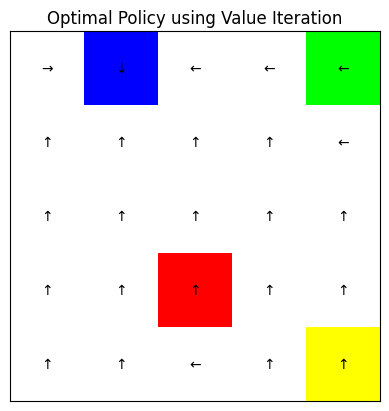

In [49]:
# Value iteration part 2

import numpy as np
import pandas as pd

# Parameters
gamma = 0.95  # discount factor
theta = 1e-6  # small threshold for convergence
actions = ['up', 'down', 'left', 'right']
action_prob = 0.25  # probability for each action

# Grid dimensions
nrows, ncols = 5, 5

# Initialize the value function
V = np.zeros((nrows, ncols))

# Special states
special_states = {
    (0, 1): {'reward': 5, 'transitions': [(3, 2)]},  # Blue square
    (0, 4): {'reward': 2.5, 'transitions': [(4, 4), (3, 2)]},  # Green square
    (3, 2): {'reward': 0},  # Red square
    (4, 4): {'reward': 0},  # Yellow square
}

# Define the possible movements
movements = {
    'up': (-1, 0),
    'down': (1, 0),
    'left': (0, -1),
    'right': (0, 1),
}

def get_next_state(row, col, action):
    move = movements[action]
    next_row = row + move[0]
    next_col = col + move[1]

    # If the agent moves off the grid, it stays in the same state
    if next_row < 0 or next_row >= nrows or next_col < 0 or next_col >= ncols:
        return row, col, -0.5  # off-grid penalty
    return next_row, next_col, 0

def value_iteration():
    while True:
        delta = 0
        new_V = np.copy(V)
        for row in range(nrows):
            for col in range(ncols):
                if (row, col) in special_states:
                    special = special_states[(row, col)]
                    v = special['reward']
                    if 'transitions' in special:
                        v += gamma * sum(
                            [V[next_row, next_col] for next_row, next_col in special['transitions']]
                        ) / len(special['transitions'])
                    new_V[row, col] = v
                else:
                    values = []
                    for action in actions:
                        next_row, next_col, reward = get_next_state(row, col, action)
                        values.append(reward + gamma * V[next_row, next_col])
                    new_V[row, col] = max(values)
                delta = max(delta, np.abs(new_V[row, col] - V[row, col]))
        V[:, :] = new_V
        if delta < theta:
            break

# Run value iteration
value_iteration()

# Display the value function grid
df = pd.DataFrame(V)
print("Value Function Grid:")
print(df)
plot_policy(V, 'Optimal Policy using Value Iteration')


In [45]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt

# # Parameters
# gamma = 0.95  # discount factor
# theta = 1e-6  # small threshold for convergence
# actions = ['up', 'down', 'left', 'right']
# action_prob = 0.25  # probability for each action

# # Grid dimensions
# nrows, ncols = 5, 5

# # Initialize the value function
# V = np.zeros((nrows, ncols))

# # Special states
# special_states = {
#     (0,1): {'reward': 5, 'transitions': [(3, 2)]},  # Blue square
#     (0, 4): {'reward': 2.5, 'transitions': [(4, 4), (3, 2)]},  # Green square
#     (3, 2): {'reward': 0},  # Red square
#     (4, 4): {'reward': 0},  # Yellow square
# }

# # Define the possible movements
# movements = {
#     'up': (-1, 0),
#     'down': (1, 0),
#     'left': (0, -1),
#     'right': (0, 1),
# }

# # Define action symbols for visualization
# action_symbols = {
#     'up': '↑',
#     'down': '↓',
#     'left': '←',
#     'right': '→',
# }

# def get_next_state(row, col, action):
#     move = movements[action]
#     next_row = row + move[0]
#     next_col = col + move[1]

#     # If the agent moves off the grid, it stays in the same state
#     if next_row < 0 or next_row >= nrows or next_col < 0 or next_col >= ncols:
#         return row, col, -0.5  # off-grid penalty
#     return next_row, next_col, 0

# def value_iteration():
#     while True:
#         delta = 0
#         new_V = np.copy(V)
#         for row in range(nrows):
#             for col in range(ncols):
#                 if (row, col) in special_states:
#                     special = special_states[(row, col)]
#                     v = special['reward']
#                     if 'transitions' in special:
#                         v += gamma * sum(
#                             [V[next_row, next_col] for next_row, next_col in special['transitions']]
#                         ) / len(special['transitions'])
#                     new_V[row, col] = v
#                 else:
#                     values = []
#                     for action in actions:
#                         next_row, next_col, reward = get_next_state(row, col, action)
#                         values.append(reward + gamma * V[next_row, next_col])
#                     new_V[row, col] = max(values)
#                 delta = max(delta, np.abs(new_V[row, col] - V[row, col]))
#         V[:, :] = new_V
#         if delta < theta:
#             break

# def extract_policy():
#     policy = np.full((nrows, ncols), None)
#     for row in range(nrows):
#         for col in range(ncols):
#             if (row, col) not in special_states:
#                 best_action = None
#                 best_value = -float('inf')
#                 for action in actions:
#                     next_row, next_col, reward = get_next_state(row, col, action)
#                     value = reward + gamma * V[next_row, next_col]
#                     if value > best_value:
#                         best_value = value
#                         best_action = action
#                 policy[row, col] = best_action
#     return policy

# # Run value iteration
# value_iteration()

# # Display the value function grid
# df = pd.DataFrame(V)
# print("Value Function Grid:")
# print(df)

# # Plot the policy
# plot_policy(V, "Optimal Policy from Value Iteration")
